In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are tested:
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10-pytorch')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. LeNet-5

**Architecture:** Input &#8594; CONV1 &#8594; ReLU &#8594; POOL2 &#8594; CONV3 &#8594; ReLU &#8594; POOL4 &#8594; CONV5 &#8594; FC6 &#8594; Softmax

![LeNet-5](images\lenet5.png)

Convolutional layers:
* **CONV1**: 6 filters and kernel size of 5 x 5
* **CONV3**: 16 filters and kernel size of 5 x 5
* **CONV5**:120 filters and kernel size of 5 x 5

Pooling Layers:
* **POOL2, POOL4**: average pooling layers with receptive field of 2 x 2.

Activations:
* Tanh activation function **(hidden layer)**
* Softmax activation function **(output layer)**

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
class LeNet5(nn.Module):
    """ Represents LeNet-5 convolutional neural network.
    
    The CNN architecture is as follows:
    Input → CONV1 → ReLU → POOL2 → CONV3 → ReLU → POOL4 → CONV5 → FC6 → Softmax
    
    The convolutional layers are configured as follows:
    * CONV1: 6 filters and kernel size of 5 x 5
    * CONV3: 16 filters and kernel size of 5 x 5
    * CONV5: 120 filters and kernel size of 5 x 5
    
    The pooling layers are configured as follwos:
    * POOL2, POOL4: average pooling layers with receptive field of 2 x 2.
    
    """
    
    def __init__(self, output_size):
        """ Initialize LeNet-5.
        
        Args:
            output_size:
                size of output (number of labels), as an integer.
        """
        super(LeNet5, self).__init__()
        
        # activation function
        self.activation = nn.Tanh()
        
        # convolutional layer: CONV1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        
        # convolutional layer: CONV3
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        # average pooling layer 
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=output_size)
        
    def forward(self, x):
        # Input --> CONV1 --> NORM --> ReLU --> POOL2
        x = self.pool(self.activation(self.conv1(x)))
        
        # CONV3 → NORM → ReLU → POOL4
        x = self.pool(self.activation(self.conv2(x)))
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        
        # CONV5
        logits = self.activation(self.fc1(x))
        
        # FC6
        logits = self.activation(self.fc2(logits))
        
        # outpout
        logits = self.fc3(logits)
        
        return logits

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| LeNet-5                       | 1.44            | 55%                 |


Best trial **configuration** for LeNet-5: lr: 0.001, l2: 0.0001

In [6]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit Convolutional Neural Network and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    model = LeNet5(output_size=num_labels)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [7]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(partial(tune_helper, 
                              trainset=trainset,
                              num_labels=num_labels,
                              batch_size=batch_size,
                              epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [8]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4]),
    }

In [9]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=10,
                    num_samples=1, 
                    cpus_per_trial=2,
                    gpus_per_trial=0)

Files already downloaded and verified
Files already downloaded and verified


2021-08-25 16:04:42,227	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 16:04:43,436	WARNING experiment.py:296 -- No name detected on trainable. Using DEFAULT.
2021-08-25 16:04:43,438	INFO registry.py:67 -- Detected unknown callable for trainable. Converting to class.
2021-08-25 16:04:43,440	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-08-25 16:04:49,028	WARNING worker.py:1189 -- Warning: The actor ImplicitFunc has size 153707832 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Memory usage on this node: 3.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_16-04-44
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------+--------+
| Trial name          | status   | loc   |     l2 |     lr |
|---------------------+----------+-------+--------+--------|
| DEFAULT_2a0e6_00000 | RUNNING  |       | 0.001  | 0.001  |
| DEFAULT_2a0e6_00001 | PENDING  |       | 0.0001 | 0.001  |
| DEFAULT_2a0e6_00002 | PENDING  |       | 0.001  | 0.0001 |
| DEFAULT_2a0e6_00003 | PENDING  |       | 0.0001 | 0.0001 |
+---------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | I

2021-08-25 16:05:36,819	WARNING util.py:164 -- The `start_trial` operation took 1.000 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5116
  date: 2021-08-25_16-05-36
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.3715806189616015
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 45.10729670524597
  time_this_iter_s: 14.621739387512207
  time_total_s: 45.10729670524597
  timestamp: 1629907536
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 2a0e6_00001
  


2021-08-25 16:05:37,768	WARNING util.py:164 -- The `start_trial` operation took 0.821 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5238
  date: 2021-08-25_16-05-50
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.3332436001224883
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 59.61804270744324
  time_this_iter_s: 14.458516120910645
  time_total_s: 59.61804270744324
  timestamp: 1629907550
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_16-

2021-08-25 16:05:51,228	WARNING util.py:164 -- The `start_trial` operation took 0.943 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5261
  date: 2021-08-25_16-05-51
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.3363525495407687
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 60.11206102371216
  time_this_iter_s: 15.004764318466187
  time_total_s: 60.11206102371216
  timestamp: 1629907551
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 2a0e6_00001
  


2021-08-25 16:05:52,746	WARNING util.py:164 -- The `start_trial` operation took 0.796 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5297
  date: 2021-08-25_16-06-04
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.322738874490094
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 74.24270033836365
  time_this_iter_s: 14.62465763092041
  time_total_s: 74.24270033836365
  timestamp: 1629907564
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_16-04

2021-08-25 16:06:05,868	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5373
  date: 2021-08-25_16-06-06
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.311415436541199
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 75.12374067306519
  time_this_iter_s: 15.011679649353027
  time_total_s: 75.12374067306519
  timestamp: 1629907566
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 2a0e6_00001
  


2021-08-25 16:06:08,097	WARNING util.py:164 -- The `start_trial` operation took 1.135 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5382
  date: 2021-08-25_16-06-19
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.2982004713860287
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 89.06914472579956
  time_this_iter_s: 14.826444387435913
  time_total_s: 89.06914472579956
  timestamp: 1629907579
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_16-

2021-08-25 16:06:20,540	WARNING util.py:164 -- The `start_trial` operation took 0.805 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.541
  date: 2021-08-25_16-06-22
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.295848498678511
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 90.38654732704163
  time_this_iter_s: 15.26280665397644
  time_total_s: 90.38654732704163
  timestamp: 1629907582
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 2a0e6_00001
  


2021-08-25 16:06:23,020	WARNING util.py:164 -- The `start_trial` operation took 0.792 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5357
  date: 2021-08-25_16-06-34
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.3197130450777188
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 104.06854891777039
  time_this_iter_s: 14.999404191970825
  time_total_s: 104.06854891777039
  timestamp: 1629907594
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_1

2021-08-25 16:06:35,615	WARNING util.py:164 -- The `start_trial` operation took 0.887 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5428
  date: 2021-08-25_16-06-37
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.3016562347958802
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 105.18041563034058
  time_this_iter_s: 14.79386830329895
  time_total_s: 105.18041563034058
  timestamp: 1629907597
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 2a0e6_00001
  


2021-08-25 16:06:37,912	WARNING util.py:164 -- The `start_trial` operation took 0.891 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5462
  date: 2021-08-25_16-06-49
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.282760839933043
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 118.91159224510193
  time_this_iter_s: 14.843043327331543
  time_total_s: 118.91159224510193
  timestamp: 1629907609
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_16

2021-08-25 16:06:50,547	WARNING util.py:164 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5568
  date: 2021-08-25_16-06-52
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.2680961800988313
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 120.1995439529419
  time_this_iter_s: 15.019128322601318
  time_total_s: 120.1995439529419
  timestamp: 1629907612
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 2a0e6_00001
  


2021-08-25 16:06:52,881	WARNING util.py:164 -- The `start_trial` operation took 0.841 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5565
  date: 2021-08-25_16-07-04
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.2794496082955864
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 133.72896909713745
  time_this_iter_s: 14.817376852035522
  time_total_s: 133.72896909713745
  timestamp: 1629907624
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_1

2021-08-25 16:07:05,257	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5557
  date: 2021-08-25_16-07-07
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.2590925473316459
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 135.28571844100952
  time_this_iter_s: 15.086174488067627
  time_total_s: 135.28571844100952
  timestamp: 1629907627
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 2a0e6_00001
  


2021-08-25 16:07:08,102	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5563
  date: 2021-08-25_16-07-19
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.2894247865221302
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 148.56341123580933
  time_this_iter_s: 14.834442138671875
  time_total_s: 148.56341123580933
  timestamp: 1629907639
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.2894247865221302
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEF

2021-08-25 16:07:20,130	WARNING util.py:164 -- The `start_trial` operation took 0.906 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5506
  date: 2021-08-25_16-07-21
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.2838618413657898
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 149.99835324287415
  time_this_iter_s: 14.712634801864624
  time_total_s: 149.99835324287415
  timestamp: 1629907641
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 2a0e6_00001
  


2021-08-25 16:07:22,740	WARNING util.py:164 -- The `start_trial` operation took 0.895 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.551
  date: 2021-08-25_16-07-33
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.2943075113235765
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 163.25818705558777
  time_this_iter_s: 14.694775819778442
  time_total_s: 163.25818705558777
  timestamp: 1629907653
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAUL

2021-08-25 16:07:34,661	WARNING util.py:164 -- The `start_trial` operation took 0.740 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5614
  date: 2021-08-25_16-07-36
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.2755144519411075
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 164.8944652080536
  time_this_iter_s: 14.896111965179443
  time_total_s: 164.8944652080536
  timestamp: 1629907656
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 2a0e6_00001
  


2021-08-25 16:07:37,598	WARNING util.py:164 -- The `start_trial` operation took 0.863 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5561
  date: 2021-08-25_16-07-48
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.2978388473486444
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 178.33160853385925
  time_this_iter_s: 15.073421478271484
  time_total_s: 178.33160853385925
  timestamp: 1629907668
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 16:07:49,833	WARNING util.py:164 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5549
  date: 2021-08-25_16-07-52
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.3081172541448265
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 180.69416666030884
  time_this_iter_s: 15.799701452255249
  time_total_s: 180.69416666030884
  timestamp: 1629907672
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 2a0e6_00001
  


2021-08-25 16:07:53,524	WARNING util.py:164 -- The `start_trial` operation took 0.991 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5547
  date: 2021-08-25_16-08-03
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.3119968957961745
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 192.93031764030457
  time_this_iter_s: 14.598709106445312
  time_total_s: 192.93031764030457
  timestamp: 1629907683
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 16:08:04,471	WARNING util.py:164 -- The `start_trial` operation took 0.881 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5516
  date: 2021-08-25_16-08-07
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.3238892669131042
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 196.0046603679657
  time_this_iter_s: 15.31049370765686
  time_total_s: 196.0046603679657
  timestamp: 1629907687
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 2a0e6_00001
  


2021-08-25 16:08:08,593	WARNING util.py:164 -- The `start_trial` operation took 0.749 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5573
  date: 2021-08-25_16-08-18
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.3188951672262448
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 207.95020866394043
  time_this_iter_s: 15.019891023635864
  time_total_s: 207.95020866394043
  timestamp: 1629907698
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 16:08:19,496	WARNING util.py:164 -- The `start_trial` operation took 0.880 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5519
  date: 2021-08-25_16-08-22
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.3353467484947983
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 211.02520942687988
  time_this_iter_s: 15.020549058914185
  time_total_s: 211.02520942687988
  timestamp: 1629907702
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 2a0e6_00001
  


2021-08-25 16:08:23,846	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5536
  date: 2021-08-25_16-08-33
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.330980672198496
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 223.0206389427185
  time_this_iter_s: 15.070430278778076
  time_total_s: 223.0206389427185
  timestamp: 1629907713
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAULT_

2021-08-25 16:08:34,569	WARNING util.py:164 -- The `start_trial` operation took 0.887 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.552
  date: 2021-08-25_16-08-37
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.3427470136599935
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 225.61309504508972
  time_this_iter_s: 14.587885618209839
  time_total_s: 225.61309504508972
  timestamp: 1629907717
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 2a0e6_00001
  


2021-08-25 16:08:38,346	WARNING util.py:164 -- The `start_trial` operation took 0.892 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5557
  date: 2021-08-25_16-08-48
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.3512208947710171
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 238.1098518371582
  time_this_iter_s: 15.089212894439697
  time_total_s: 238.1098518371582
  timestamp: 1629907728
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAULT

2021-08-25 16:08:49,596	WARNING util.py:164 -- The `start_trial` operation took 0.829 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5555
  date: 2021-08-25_16-08-52
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.3586959694601168
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 240.73408722877502
  time_this_iter_s: 15.120992183685303
  time_total_s: 240.73408722877502
  timestamp: 1629907732
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 2a0e6_00001
  


2021-08-25 16:08:53,414	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5555
  date: 2021-08-25_16-09-03
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.37045090175738
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 252.79301381111145
  time_this_iter_s: 14.683161973953247
  time_total_s: 252.79301381111145
  timestamp: 1629907743
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAULT

2021-08-25 16:09:04,277	WARNING util.py:164 -- The `start_trial` operation took 0.824 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5499
  date: 2021-08-25_16-09-07
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.3818330647079808
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 255.63423323631287
  time_this_iter_s: 14.900146007537842
  time_total_s: 255.63423323631287
  timestamp: 1629907747
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 2a0e6_00001
  


2021-08-25 16:09:08,390	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5564
  date: 2021-08-25_16-09-18
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.3897089984766238
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 267.66051983833313
  time_this_iter_s: 14.86750602722168
  time_total_s: 267.66051983833313
  timestamp: 1629907758
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAUL

2021-08-25 16:09:19,135	WARNING util.py:164 -- The `start_trial` operation took 0.813 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.547
  date: 2021-08-25_16-09-22
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.4036610490956885
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 270.39733242988586
  time_this_iter_s: 14.763099193572998
  time_total_s: 270.39733242988586
  timestamp: 1629907762
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 2a0e6_00001
  


2021-08-25 16:09:23,164	WARNING util.py:164 -- The `start_trial` operation took 0.929 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5464
  date: 2021-08-25_16-09-33
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4058380749574892
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 282.79311895370483
  time_this_iter_s: 15.132599115371704
  time_total_s: 282.79311895370483
  timestamp: 1629907773
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 16:09:34,213	WARNING util.py:164 -- The `start_trial` operation took 0.760 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5521
  date: 2021-08-25_16-09-36
  done: false
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.4343981317653778
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 285.14921045303345
  time_this_iter_s: 14.751878023147583
  time_total_s: 285.14921045303345
  timestamp: 1629907776
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 2a0e6_00001
  


2021-08-25 16:09:37,955	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.55
  date: 2021-08-25_16-09-47
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.4161121609863963
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 297.3426854610443
  time_this_iter_s: 14.549566507339478
  time_total_s: 297.3426854610443
  timestamp: 1629907787
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4161121609863963 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_re

2021-08-25 16:09:48,806	WARNING util.py:164 -- The `start_trial` operation took 0.805 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00001:
  accuracy: 0.5529
  date: 2021-08-25_16-09-52
  done: true
  experiment_id: e42c3acb340c4a7c9dac6ad059ee2bef
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.442167763877067
  node_ip: 10.0.0.4
  pid: 2420
  time_since_restore: 300.39726853370667
  time_this_iter_s: 15.248058080673218
  time_total_s: 300.39726853370667
  timestamp: 1629907792
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 2a0e6_00001
  


2021-08-25 16:09:53,397	WARNING util.py:164 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 3.6/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_16-04-44
Number of trials: 4/4 (1 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+---------------+--------+--------+---------+------------+----------------------+
| Trial name          | status     | loc           |     l2 |     lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+---------------+--------+--------+---------+------------+----------------------|
| DEFAULT_2a0e6_00000 

2021-08-25 16:09:54,227	WARNING util.py:164 -- The `start_trial` operation took 0.825 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5581
  date: 2021-08-25_16-10-02
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.4056804533217364
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 311.66127920150757
  time_this_iter_s: 14.318593740463257
  time_total_s: 311.66127920150757
  timestamp: 1629907802
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ra

2021-08-25 16:10:03,245	WARNING util.py:164 -- The `start_trial` operation took 0.919 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.3416
  date: 2021-08-25_16-10-09
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8620007964456158
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 14.47046160697937
  time_this_iter_s: 14.47046160697937
  time_total_s: 14.47046160697937
  timestamp: 1629907809
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_res

2021-08-25 16:10:10,397	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5569
  date: 2021-08-25_16-10-17
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.4090083222480336
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 326.4413962364197
  time_this_iter_s: 14.78011703491211
  time_total_s: 326.4413962364197
  timestamp: 1629907817
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_r

2021-08-25 16:10:17,957	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.3772
  date: 2021-08-25_16-10-24
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7662702510311346
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 29.221903562545776
  time_this_iter_s: 14.751441955566406
  time_total_s: 29.221903562545776
  timestamp: 1629907824
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_

2021-08-25 16:10:25,121	WARNING util.py:164 -- The `start_trial` operation took 0.847 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.557
  date: 2021-08-25_16-10-31
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 23
  loss: 1.4224807304941165
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 341.2213225364685
  time_this_iter_s: 14.779926300048828
  time_total_s: 341.2213225364685
  timestamp: 1629907831
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_r

2021-08-25 16:10:32,662	WARNING util.py:164 -- The `start_trial` operation took 0.780 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.3928
  date: 2021-08-25_16-10-39
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.714717102658217
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 44.08219122886658
  time_this_iter_s: 14.8602876663208
  time_total_s: 44.08219122886658
  timestamp: 1629907839
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_resul

2021-08-25 16:10:40,012	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5575
  date: 2021-08-25_16-10-46
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 24
  loss: 1.4276058468849036
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 356.16787815093994
  time_this_iter_s: 14.946555614471436
  time_total_s: 356.16787815093994
  timestamp: 1629907846
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ra

2021-08-25 16:10:47,694	WARNING util.py:164 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.4084
  date: 2021-08-25_16-10-53
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.674052924107594
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 58.94308853149414
  time_this_iter_s: 14.860897302627563
  time_total_s: 58.94308853149414
  timestamp: 1629907853
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_res

2021-08-25 16:10:54,787	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5566
  date: 2021-08-25_16-11-01
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 25
  loss: 1.44033944606781
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 370.7685670852661
  time_this_iter_s: 14.600688934326172
  time_total_s: 370.7685670852661
  timestamp: 1629907861
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_re

2021-08-25 16:11:02,465	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.422
  date: 2021-08-25_16-11-08
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.6427515441445029
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 73.67235541343689
  time_this_iter_s: 14.729266881942749
  time_total_s: 73.67235541343689
  timestamp: 1629907868
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_res

2021-08-25 16:11:09,659	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5584
  date: 2021-08-25_16-11-16
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.4488629945524178
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 385.61719584465027
  time_this_iter_s: 14.848628759384155
  time_total_s: 385.61719584465027
  timestamp: 1629907876
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ra

2021-08-25 16:11:17,176	WARNING util.py:164 -- The `start_trial` operation took 0.896 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.4297
  date: 2021-08-25_16-11-23
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.621720585853431
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 88.35586810112
  time_this_iter_s: 14.683512687683105
  time_total_s: 88.35586810112
  timestamp: 1629907883
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/D

2021-08-25 16:11:24,137	WARNING util.py:164 -- The `start_trial` operation took 0.727 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5573
  date: 2021-08-25_16-11-31
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 27
  loss: 1.4684472327019757
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 400.7169246673584
  time_this_iter_s: 15.09972882270813
  time_total_s: 400.7169246673584
  timestamp: 1629907891
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_r

2021-08-25 16:11:32,232	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.4364
  date: 2021-08-25_16-11-38
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.5898351805984594
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 103.33126473426819
  time_this_iter_s: 14.975396633148193
  time_total_s: 103.33126473426819
  timestamp: 1629907898
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_

2021-08-25 16:11:39,182	WARNING util.py:164 -- The `start_trial` operation took 0.794 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5558
  date: 2021-08-25_16-11-46
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 28
  loss: 1.469064014732458
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 415.7533838748932
  time_this_iter_s: 15.03645920753479
  time_total_s: 415.7533838748932
  timestamp: 1629907906
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_re

2021-08-25 16:11:47,355	WARNING util.py:164 -- The `start_trial` operation took 0.943 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.4484
  date: 2021-08-25_16-11-52
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.5649318664696565
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 117.81871604919434
  time_this_iter_s: 14.487451314926147
  time_total_s: 117.81871604919434
  timestamp: 1629907912
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_

2021-08-25 16:11:53,676	WARNING util.py:164 -- The `start_trial` operation took 0.803 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5545
  date: 2021-08-25_16-12-01
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.478205980768629
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 430.8000214099884
  time_this_iter_s: 15.046637535095215
  time_total_s: 430.8000214099884
  timestamp: 1629907921
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b)
Result logdir: /home/lampros/ray_r

2021-08-25 16:12:02,382	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.4525
  date: 2021-08-25_16-12-07
  done: false
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.5379937112711037
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 132.39396691322327
  time_this_iter_s: 14.57525086402893
  time_total_s: 132.39396691322327
  timestamp: 1629907927
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_r

2021-08-25 16:12:08,230	WARNING util.py:164 -- The `start_trial` operation took 0.785 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5549
  date: 2021-08-25_16-12-16
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 30
  loss: 1.48002810690813
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 445.86261534690857
  time_this_iter_s: 15.062593936920166
  time_total_s: 445.86261534690857
  timestamp: 1629907936
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.28664331394396
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_

2021-08-25 16:12:17,404	WARNING util.py:164 -- The `start_trial` operation took 0.881 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00002:
  accuracy: 0.4659
  date: 2021-08-25_16-12-22
  done: true
  experiment_id: 06be67a3598243bdb48f2ea00ae7b086
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.5094850579644465
  node_ip: 10.0.0.4
  pid: 2419
  time_since_restore: 147.3376305103302
  time_this_iter_s: 14.943663597106934
  time_total_s: 147.3376305103302
  timestamp: 1629907942
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 2a0e6_00002
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.2894247865221302
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray

2021-08-25 16:12:23,709	WARNING util.py:164 -- The `start_trial` operation took 1.313 s, which may be a performance bottleneck.


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5553
  date: 2021-08-25_16-12-30
  done: false
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 31
  loss: 1.492192096011654
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 459.9996380805969
  time_this_iter_s: 14.137022733688354
  time_total_s: 459.9996380805969
  timestamp: 1629907950
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 4.0/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.2894247865221302
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fbbbb88a2bced46dd1e84a926791547b, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray

2021-08-25 16:24:27,136	INFO tune.py:550 -- Total run time: 1183.70 seconds (1182.04 seconds for the tuning loop).


Result for DEFAULT_2a0e6_00000:
  accuracy: 0.5543
  date: 2021-08-25_16-24-27
  done: true
  experiment_id: 61ff0ed8e2d9480c9227496d24847447
  hostname: cbir
  iterations_since_restore: 100
  loss: 1.5076842262486743
  node_ip: 10.0.0.4
  pid: 2422
  time_since_restore: 1176.371881723404
  time_this_iter_s: 9.586799144744873
  time_total_s: 1176.371881723404
  timestamp: 1629908667
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 2a0e6_00000
  
== Status ==
Memory usage on this node: 3.5/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: -1.4998425154169654 | Iter 40.000: -1.4985681286283359 | Iter 20.000: -1.4291399624317316 | Iter 10.000: -1.3770076015572639
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/3.78 GiB heap, 0.0/1.89 GiB objects (0.0/2.0 CPU_group_fe64c4faeeb582eef4f0db80729f6a47, 0.0/2.0 CPU_group_0_fe64c4faeeb582eef4f0db80729f6a47)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_16-04-44
Number of trials: 4/4 (4 TERMINATED)
+--

# 4. Fit and Predict

In [6]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit LeNet-5.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            convolutional neural network, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [7]:
def predict(dataloader, num_labels, model, loss_fn):
    """ Predict with Convolutional Neural Network.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        num_labels:
            number of labels, as integer.
        model:
            neural network, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
    
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.001, l2: 0.0001

Results:
* Best **epoch**: 17
* Best **train**: **accuracy**: 72.2%, **avg loss**: 0.787027
* Best **test**: **accuracy**: 56.7%, **avg loss**: 1.329359

In [8]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [10]:
num_labels = 10

model = LeNet5(output_size=num_labels).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
LeNet5(
  (activation): Tanh()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
learning_rate = 0.001
weight_decay = 0.0001

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

## 5.2 Fit and predict

In [12]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, num_labels, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, num_labels, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        best_model_state_dict = model.state_dict()
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------
loss: 2.296298 [    0/50000]
loss: 1.671323 [ 6400/50000]
loss: 1.672283 [12800/50000]
loss: 1.788687 [19200/50000]
loss: 1.640212 [25600/50000]
loss: 1.815406 [32000/50000]
loss: 1.644395 [38400/50000]
loss: 1.891762 [44800/50000]

Train:
-------
accuracy: 45.2%, avg loss: 1.547675

Test:
-------
accuracy: 44.5%, avg loss: 1.554110

-------------------------------
Epoch 2
-------------------------------
loss: 1.475846 [    0/50000]
loss: 1.414184 [ 6400/50000]
loss: 1.485317 [12800/50000]
loss: 1.359556 [19200/50000]
loss: 1.760148 [25600/50000]
loss: 1.391958 [32000/50000]
loss: 1.329829 [38400/50000]
loss: 1.359778 [44800/50000]

Train:
-------
accuracy: 50.4%, avg loss: 1.389502

Test:
-------
accuracy: 48.5%, avg loss: 1.431361

-------------------------------
Epoch 3
-------------------------------
loss: 1.547193 [    0/50000]
loss: 1.398715 [ 6400/50000]
loss: 1.385411 [12800/50000]
loss: 1.367004 [19200/50000]
loss: 1.548895 [25600/50000]

loss: 0.722111 [ 6400/50000]
loss: 0.775939 [12800/50000]
loss: 1.033973 [19200/50000]
loss: 0.889407 [25600/50000]
loss: 0.652754 [32000/50000]
loss: 0.611888 [38400/50000]
loss: 0.837537 [44800/50000]

Train:
-------
accuracy: 76.2%, avg loss: 0.681944

Test:
-------
accuracy: 55.3%, avg loss: 1.402633

-------------------------------
Epoch 22
-------------------------------
loss: 0.668666 [    0/50000]
loss: 0.488771 [ 6400/50000]
loss: 0.652840 [12800/50000]
loss: 0.538306 [19200/50000]
loss: 0.634589 [25600/50000]
loss: 0.542466 [32000/50000]
loss: 0.602137 [38400/50000]
loss: 0.599942 [44800/50000]

Train:
-------
accuracy: 79.8%, avg loss: 0.607296

Test:
-------
accuracy: 56.4%, avg loss: 1.373639

-------------------------------
Epoch 23
-------------------------------
loss: 0.603100 [    0/50000]
loss: 0.592791 [ 6400/50000]
loss: 0.453702 [12800/50000]
loss: 0.465340 [19200/50000]
loss: 0.553463 [25600/50000]
loss: 0.731101 [32000/50000]
loss: 0.557989 [38400/50000]
loss: 0.

loss: 0.577859 [12800/50000]
loss: 0.476270 [19200/50000]
loss: 0.494184 [25600/50000]
loss: 0.719522 [32000/50000]
loss: 0.471245 [38400/50000]
loss: 0.593807 [44800/50000]

Train:
-------
accuracy: 82.4%, avg loss: 0.542061

Test:
-------
accuracy: 56.1%, avg loss: 1.466041

-------------------------------
Epoch 42
-------------------------------
loss: 0.709254 [    0/50000]
loss: 0.466767 [ 6400/50000]
loss: 0.472508 [12800/50000]
loss: 0.502202 [19200/50000]
loss: 0.590024 [25600/50000]
loss: 0.523714 [32000/50000]
loss: 0.532811 [38400/50000]
loss: 0.455153 [44800/50000]

Train:
-------
accuracy: 82.4%, avg loss: 0.541787

Test:
-------
accuracy: 56.1%, avg loss: 1.467685

-------------------------------
Epoch 43
-------------------------------
loss: 0.539439 [    0/50000]
loss: 0.449836 [ 6400/50000]
loss: 0.470805 [12800/50000]
loss: 0.433514 [19200/50000]
loss: 0.653467 [25600/50000]
loss: 0.721278 [32000/50000]
loss: 0.432168 [38400/50000]
loss: 0.523113 [44800/50000]

Train:


loss: 0.427676 [19200/50000]
loss: 0.545539 [25600/50000]
loss: 0.677832 [32000/50000]
loss: 0.404314 [38400/50000]
loss: 0.569145 [44800/50000]

Train:
-------
accuracy: 82.4%, avg loss: 0.541078

Test:
-------
accuracy: 56.1%, avg loss: 1.469199

-------------------------------
Epoch 62
-------------------------------
loss: 0.374118 [    0/50000]
loss: 0.415352 [ 6400/50000]
loss: 0.572935 [12800/50000]
loss: 0.526829 [19200/50000]
loss: 0.688350 [25600/50000]
loss: 0.789653 [32000/50000]
loss: 0.499274 [38400/50000]
loss: 0.601815 [44800/50000]

Train:
-------
accuracy: 82.4%, avg loss: 0.540710

Test:
-------
accuracy: 56.1%, avg loss: 1.469208

-------------------------------
Epoch 63
-------------------------------
loss: 0.683650 [    0/50000]
loss: 0.725373 [ 6400/50000]
loss: 0.519325 [12800/50000]
loss: 0.408473 [19200/50000]
loss: 0.601294 [25600/50000]
loss: 0.563801 [32000/50000]
loss: 0.535793 [38400/50000]
loss: 0.547488 [44800/50000]

Train:
-------
accuracy: 82.4%, avg 

loss: 0.483876 [25600/50000]
loss: 0.428149 [32000/50000]
loss: 0.541272 [38400/50000]
loss: 0.401666 [44800/50000]

Train:
-------
accuracy: 82.4%, avg loss: 0.540694

Test:
-------
accuracy: 56.1%, avg loss: 1.469235

-------------------------------
Epoch 82
-------------------------------
loss: 0.527892 [    0/50000]
loss: 0.723353 [ 6400/50000]
loss: 0.425395 [12800/50000]
loss: 0.542385 [19200/50000]
loss: 0.555321 [25600/50000]
loss: 0.443431 [32000/50000]
loss: 0.327344 [38400/50000]
loss: 0.672659 [44800/50000]

Train:
-------
accuracy: 82.4%, avg loss: 0.540739

Test:
-------
accuracy: 56.1%, avg loss: 1.469236

-------------------------------
Epoch 83
-------------------------------
loss: 0.494597 [    0/50000]
loss: 0.510760 [ 6400/50000]
loss: 0.562302 [12800/50000]
loss: 0.395106 [19200/50000]
loss: 0.444333 [25600/50000]
loss: 0.622606 [32000/50000]
loss: 0.740476 [38400/50000]
loss: 0.622597 [44800/50000]

Train:
-------
accuracy: 82.4%, avg loss: 0.540968

Test:
-------

## 5.3 Visualize training and testing

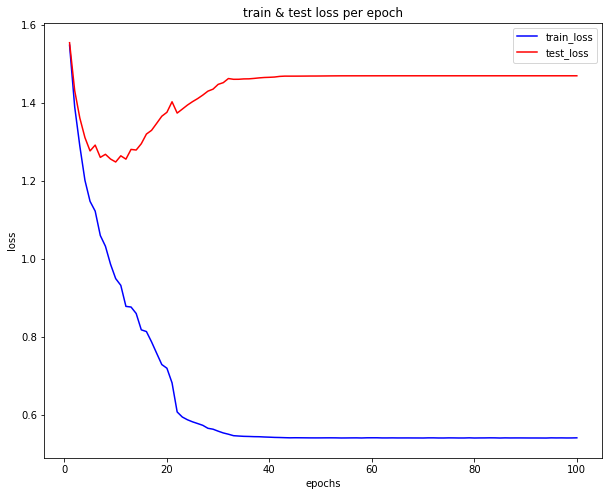

In [13]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

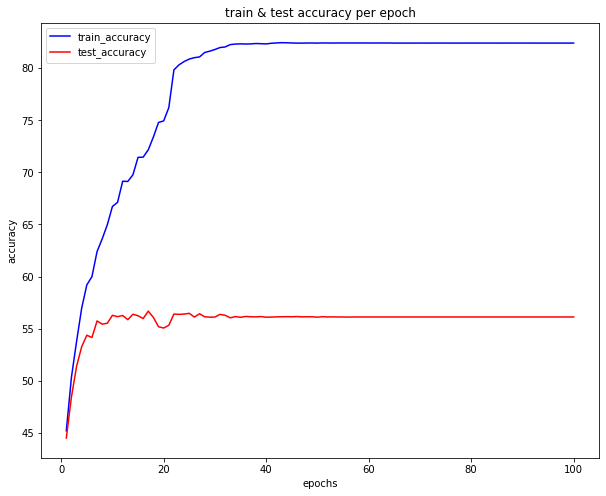

In [14]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [15]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 17
Train: accuracy: 72.2%, avg loss: 0.787027
Test: accuracy: 56.7%, avg loss: 1.329359


## 5.4 Model metrics

In [16]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.80      0.73      0.76      5000
  automobile       0.86      0.81      0.84      5000
        bird       0.65      0.61      0.63      5000
         cat       0.56      0.48      0.52      5000
        deer       0.71      0.64      0.68      5000
         dog       0.57      0.68      0.62      5000
        frog       0.75      0.80      0.78      5000
       horse       0.82      0.74      0.78      5000
        ship       0.74      0.89      0.81      5000
       truck       0.76      0.83      0.79      5000

    accuracy                           0.72     50000
   macro avg       0.72      0.72      0.72     50000
weighted avg       0.72      0.72      0.72     50000

Test:
              precision    recall  f1-score   support

    airplane       0.64      0.59      0.61      1000
  automobile       0.69      0.66      0.67      1000
        bird       0.46      0.43      0.45      1000
         ca

<AxesSubplot:>

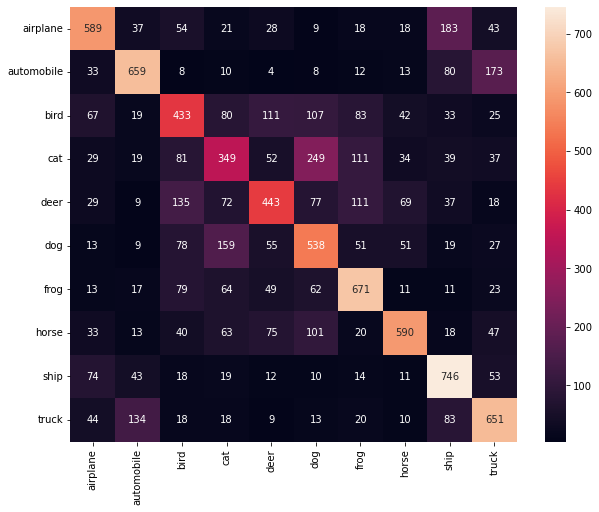

In [17]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [18]:
torch.save(best_model_state_dict, '../saved-model/lenet5-weights.pth')